## Deep learning based on CNNs 

In [34]:
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import cv2
import os
import os, sys
from sklearn.metrics import classification_report
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score

## Data
We decided to use the proposed FER2013 dataset to train and test our model.

In [35]:
data = pd.read_csv("fer2013.csv")
data.head(20)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [36]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [37]:
training = data.loc[data["Usage"] == "Training"]
validation = data.loc[data["Usage"] == "PrivateTest"]
test = data.loc[data["Usage"] == "PublicTest"]

print("Shape trainig set = ", training.shape)
print("Shape test set = ", test.shape)
print("Shape validation set = ", validation.shape)

Shape trainig set =  (28709, 3)
Shape test set =  (3589, 3)
Shape validation set =  (3589, 3)


In this set, there are 28709 training instances and 3589 test and validation instances.
The set contains of 3 columns, the first column is the emotion, which is the outcome variable. 
The second column are the pixels. Those pixels will be put into a list and since the images are 48x48 gray scale images, we have to reshape the pixels into (x, 48, 48, 1) arrays. The last thing we need to do is to standardize the pixels to get a value between 0 and 1.

In [38]:
train_emotions = training["emotion"]
train_emotions = to_categorical(train_emotions)


val_emotions = validation["emotion"]
val_emotions = to_categorical(val_emotions)

test_emotions = test["emotion"]
test_emotions = to_categorical(test_emotions)

train_images = training["pixels"].str.split(" ").tolist()
train_images = np.uint8(train_images)
train_images = train_images.reshape((28709, 48, 48, 1))
train_images = train_images.astype("float32") / 255


val_images = validation["pixels"].str.split(" ").tolist()
val_images = np.uint8(val_images)
val_images = val_images.reshape((3589, 48, 48, 1))
val_images = val_images.astype("float32") / 255


test_images = test["pixels"].str.split(" ").tolist()
test_images = np.uint8(test_images)
test_images = test_images.reshape((3589, 48, 48, 1))
test_images = test_images.astype("float32") / 255

In [39]:
test_emotions

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

The next step is to plot some of the images to see how they look like.

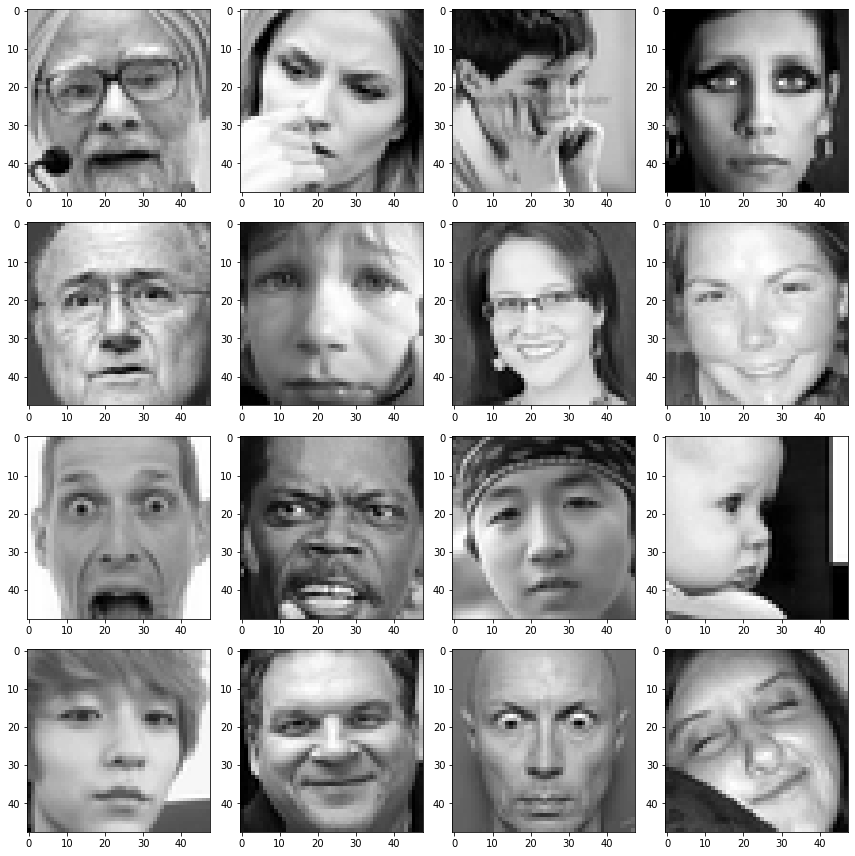

In [40]:
plt.figure(0, figsize=(12,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    plt.imshow(train_images[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()


## Video

In the code below you can find the code we created to get faces from a video. 
First we get frames out of the video's and we'll make them grayscale.

The next step is to detect faces, then we draw a rectangle around them and we resize them to make sure they have the same shape as the input images of our model. 

In [41]:
def load_images_from_folder(path):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images.append(img)
    return images

In [57]:
def resize(path):
    for i in os.listdir(path):
        file = f"{path}\\{i}"
        im = Image.open(file)
        im = im.resize((48, 48), Image.ANTIALIAS)
        im.save(file)

In [43]:
def RGBtoGray(image):
    
    img_gray=np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    return img_gray

In [44]:
def getFrames(video,path):
    vidcap = cv2.VideoCapture(video)
    success,image = vidcap.read()
    count = 0
    while success:
        cv2.imwrite(os.path.join(path,"frame%d.jpg" % count),image)

        success,image = vidcap.read()
        print('Read a new frame: ', count)
        count += 1

In [45]:
def detectFaces(frame,path,i):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # Draw rectangle around the faces and crop the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
        faces = frame[y:y + h, x:x + w]

        #cv2.imwrite('face.jpg', faces)

    # Display the output
    cv2.imwrite(os.path.join(path,"face%d.jpg" % i),faces)

In [53]:
path = r'C:\Users\tmahe\OneDrive\Documents\GitHub\Computer-vision-deep-learning\video frames'
path2 = r'C:\Users\tmahe\OneDrive\Documents\GitHub\Computer-vision-deep-learning\faces'
path3 = r'C:\Users\tmahe\OneDrive\Documents\GitHub\Computer-vision-deep-learning\resized'
video = 'video.mp4'

In [54]:
getFrames(video,path)

In [55]:
frames = load_images_from_folder(path)
for i in range(0,len(frames)):
    detectFaces(frames[i][:][:][:],path2,i)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205


In [58]:
resize(path2)

In [59]:
faces = load_images_from_folder(path2)
gray_Video_Faces = []
for i in range(0,len(faces)):
    gray_Video_Faces1 = RGBtoGray(faces[i][:][:][:])
    gray_Video_Faces.append(gray_Video_Faces1)

In [60]:

gray_Video_Faces = np.reshape(gray_Video_Faces,(len(gray_Video_Faces),48,48,1))
gray_Video_Faces = gray_Video_Faces.astype("float32") / 255

np.shape(gray_Video_Faces)

(206, 48, 48, 1)

## Model

The first step is to define the model and all the parameters.

In [ ]:
def model_test(filters, layer_size, pool_size, stride_size,dropout,activation,dense):
    model = models.Sequential()
    if layer_size == 1:
        model.add(layers.Conv2D(filters[0], (kernel_size, kernel_size), activation=activation, input_shape=(48,48,1)))
    elif layer_size == 3:
        model.add(layers.Conv2D(filters[0], (kernel_size, kernel_size), activation=activation, input_shape=(48,48,1)))
        model.add(layers.MaxPooling2D(pool_size=(pool_size,pool_size), strides=(stride_size, stride_size)))
        model.add(layers.Conv2D(filters[0], (3, 3), activation=activation))
        model.add(layers.Conv2D(filters[0], (3, 3), activation=activation))
    elif layer_size == 5:
        model.add(layers.Conv2D(filters[0], (kernel_size, kernel_size), activation=activation, input_shape=(48,48,1)))
        model.add(layers.MaxPooling2D(pool_size=(pool_size,pool_size), strides=(stride_size, stride_size)))
        
        model.add(layers.Conv2D(filters[0], (3, 3), activation=activation))
        model.add(layers.Conv2D(filters[0], (3, 3), activation=activation))
        
        model.add(layers.AveragePooling2D(pool_size=(pool_size,pool_size), strides=(stride_size, stride_size)))
        
        model.add(layers.Conv2D(filters[1], (3, 3), activation=activation))
        model.add(layers.Conv2D(filters[1], (3, 3), activation=activation))
        
        model.add(layers.AveragePooling2D(pool_size=(pool_size,pool_size), strides=(stride_size, stride_size)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense, activation=activation))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Dense(dense, activation=activation))
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(7, activation='softmax'))
    return model

In the next step, the model will be trained.

In [ ]:
layer_size = 5
kernel_size = 3
filters = [64,128]
pool_size = 3
stride_size = 2
dropout = 0.3
activation =  'relu'
optimizer = 'adam'
dense = 256
model = model_test(filters, layer_size, pool_size, stride_size,dropout,activation,dense)
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

hist = model.fit(train_images, train_emotions, batch_size = 256, epochs = 30,
                validation_data = (val_images, val_emotions))


In [ ]:
acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "train")
plt.plot(epochs, val_acc, "b", label = "validation")
plt.title("accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label = "train")
plt.plot(epochs, val_loss, "b", label = "validation")
plt.title("loss")
plt.legend()


plt.show()

In [61]:
Y_pred = model.predict(test_images)
Y_pred1 = np.zeros_like(Y_pred)
Y_pred1[np.arange(len(Y_pred)), Y_pred.argmax(1)] = 1

Video prediction:

result video = [6.5107155e-03 2.6446956e-04 1.3017808e-02 9.5236182e-01 7.9552177e-03
 2.8078898e-03 1.7081983e-02]
[0.         0.         0.01941748 0.9611651  0.         0.
 0.01941748]
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
[0. 0. 0. 1. 0. 0. 0.]


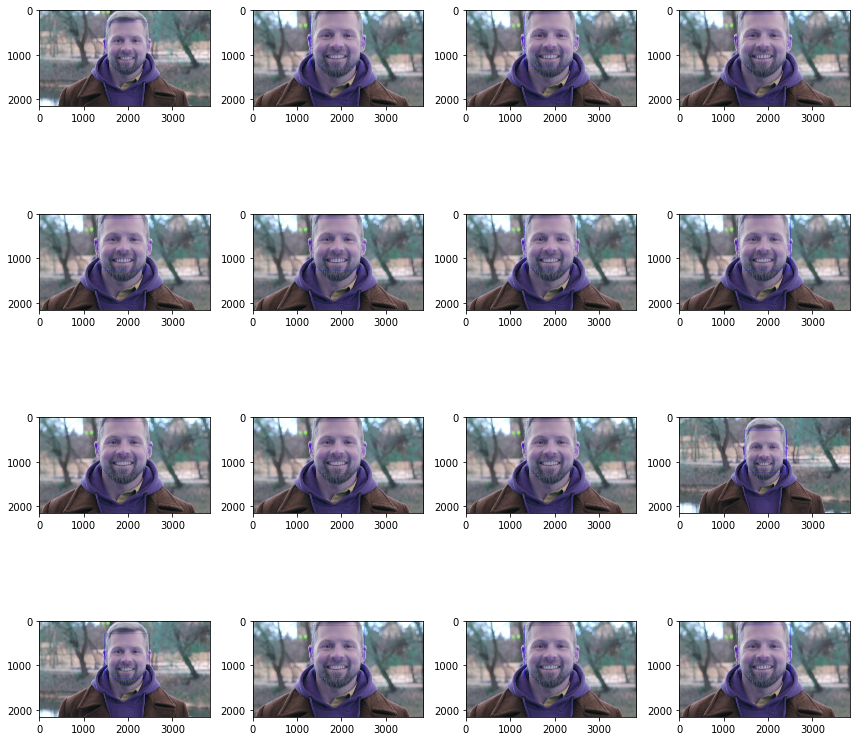

In [93]:

predVideo = model.predict(gray_Video_Faces)

pred_video_max = np.zeros_like(predVideo)
pred_video_max[np.arange(len(predVideo)), predVideo.argmax(1)] = 1
result_video = np.mean(predVideo, axis = 0)
result_video1 = np.mean(pred_video_max, axis = 0)


result_video_max = np.zeros_like(result_video)
max_value = np.max(result_video)
result_video_max[np.where(result_video == max_value)] = 1


print('result video =' ,result_video)
print(result_video1)
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad','surprise']
print(target_names)
print(result_video_max)

plt.figure(0, figsize=(12,12))
for i in range(101, 117):
    plt.subplot(4,4,i-100)
    plt.imshow(frames[i][:][:][:], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:

print(classification_report(test_emotions, Y_pred1, target_names=target_names))
print("test1: \n", confusion_matrix(np.argmax(test_emotions, axis=1), np.argmax(Y_pred , axis=1)))
print("acc1: ", accuracy_score(np.argmax(test_emotions, axis=1), np.argmax(Y_pred , axis=1)))

In [ ]:
plt.figure(0, figsize=(12,6))
for i in range(31, 43):
    plt.subplot(3,4,i-30)
    plt.imshow(test_images[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

## Experiments

In [189]:
layer_size = 5
kernel_size = 3
filters = [64,128]
pool_size = 3
stride_size = 2
dropout = 0.3
activation =  'relu'
optimizer = 'adam'
dense = 256
accuracy1 =[]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True, min_delta=0.001)
model1 = model_test(filters, layer_size, pool_size, stride_size,dropout,activation,dense)
model1.summary()
model1.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics = ["accuracy"])
hist1 = model1.fit(train_images, train_emotions, batch_size = 256, epochs = 50,
                    validation_data = (val_images, val_emotions),callbacks=[early_stopping])
Y_pred = model1.predict(test_images)
Y_pred1 = np.zeros_like(Y_pred)
Y_pred1[np.arange(len(Y_pred)), Y_pred.argmax(1)] = 1
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad','surprise']
print(classification_report(test_emotions, Y_pred1, target_names=target_names))
print("test1: \n", confusion_matrix(np.argmax(test_emotions, axis=1), np.argmax(Y_pred , axis=1)))
accuracy_1 = accuracy_score(np.argmax(test_emotions, axis=1), np.argmax(Y_pred , axis=1))
accuracy1.append(accuracy_1)
print("acc1: ", accuracy_score(np.argmax(test_emotions, axis=1), np.argmax(Y_pred , axis=1)))

    

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 conv2d_53 (Conv2D)          (None, 18, 18, 64)        36928     
                                                                 
 average_pooling2d_10 (Avera  (None, 8, 8, 64)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_54 (Conv2D)          (None, 6, 6, 128)       

In [ ]:
layer_size = 3
kernel_size = 5
filters = [64,128]
pool_size = 3
stride_size = 2
dropout = 0.2
activation = ['relu', 'sigmoid', 'tanh']
optimizer = 'adam'
dense = 256
accuracy2 =[]
for d in activation:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True, min_delta=0.001)
    model2 = model_test(filters, layer_size, pool_size, stride_size,dropout,d,dense)
    model2.summary()
    model2.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

    hist2 = model2.fit(train_images, train_emotions, batch_size = 256, epochs = 30,
                        validation_data = (val_images, val_emotions),callbacks=[early_stopping])
    Y_pred = model2.predict(test_images)
    Y_pred1 = np.zeros_like(Y_pred)
    Y_pred1[np.arange(len(Y_pred)), Y_pred.argmax(1)] = 1
    target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad','surprise']
    print(classification_report(test_emotions, Y_pred1, target_names=target_names))
    print("test1: \n", confusion_matrix(np.argmax(test_emotions, axis=1), np.argmax(Y_pred , axis=1)))
    accuracy_1 = accuracy_score(np.argmax(test_emotions, axis=1), np.argmax(Y_pred , axis=1))
    accuracy2.append(accuracy_1)
    print("acc1: ", accuracy_score(np.argmax(test_emotions, axis=1), np.argmax(Y_pred , axis=1)))

In [ ]:
import csv  

with open('activation_function.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['relu','sigmoid','tanh'])

    # write the data
    writer.writerow(accuracy)
    
with open('optimizer.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['adam', 'AdaGrad', 'RMSProp'])

    # write the data
    writer.writerow(accuracy1)
    
with open('dense.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(dense)

    # write the data
    writer.writerow(accuracy2)


## Visualize filters

conv2d_3 (5, 5, 1, 64)
5


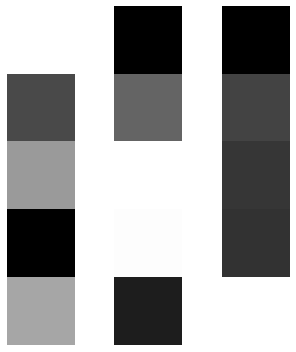

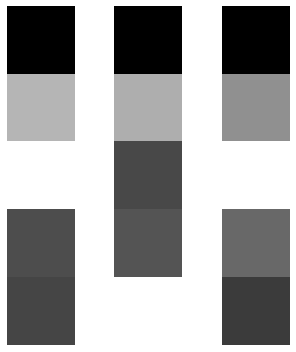

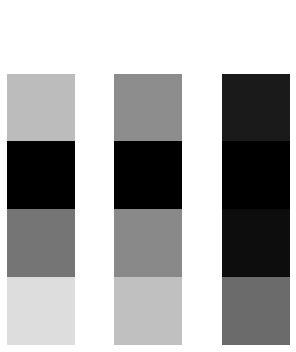

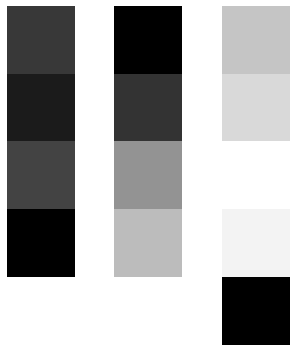

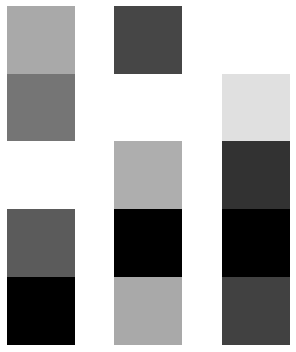

conv2d_4 (3, 3, 64, 64)
3


conv2d_5 (3, 3, 64, 64)
3


In [63]:
def visual_filters():
    for layer in model.layers:
        if 'conv' in layer.name:
            filters, bias= layer.get_weights()
            print(layer.name, filters.shape)
             #normalize filter values between  0 and 1 for visualization
            f_min, f_max = filters.min(), filters.max()
            filters = (filters - f_min) / (f_max - f_min)  
            print(filters.shape[0])
            axis_x=1
            #plotting all the filters
            for i in range(filters.shape[0]):
            #for i in range(6):
                #get the filters
                filt=filters[:,:,:,i]
                fig, axes = plt.subplots(1, 3, figsize=(5,5))
                axes = axes.flatten()
                for img, ax in zip( filt, axes):
                    ax.imshow(img, cmap='gray')
                    ax.axis('off')
                plt.tight_layout()
                plt.show()
                
             
            


In [180]:
def get_output_after_filter(model, number_layer, num_testimage):
    model3 = Model(inputs=model.inputs , outputs=model.layers[number_layer].output)
    image=test_images[num_testimage, :, :, 0]
    
    image = img_to_array(image)
    # expand dimensions so that it represents a single 'sample'
    image = expand_dims(image, axis=0)
    
    #image = preprocess_input(image)
    
    features = model3.predict(image)
    
    fig = pyplot.figure(figsize=(16,4))
    for i in range(1,features.shape[3]+1):
        if features.shape[3]==64:
    
            pyplot.subplot(4,16,i)
            pyplot.axis('off')
            pyplot.imshow(features[0,:,:,i-1] , cmap='gray')
            pyplot.axis('off')
            
        elif features.shape[3]==128:
    
            pyplot.subplot(8,16,i)
            pyplot.axis('off')
            pyplot.imshow(features[0,:,:,i-1] , cmap='gray')
    pyplot.show()

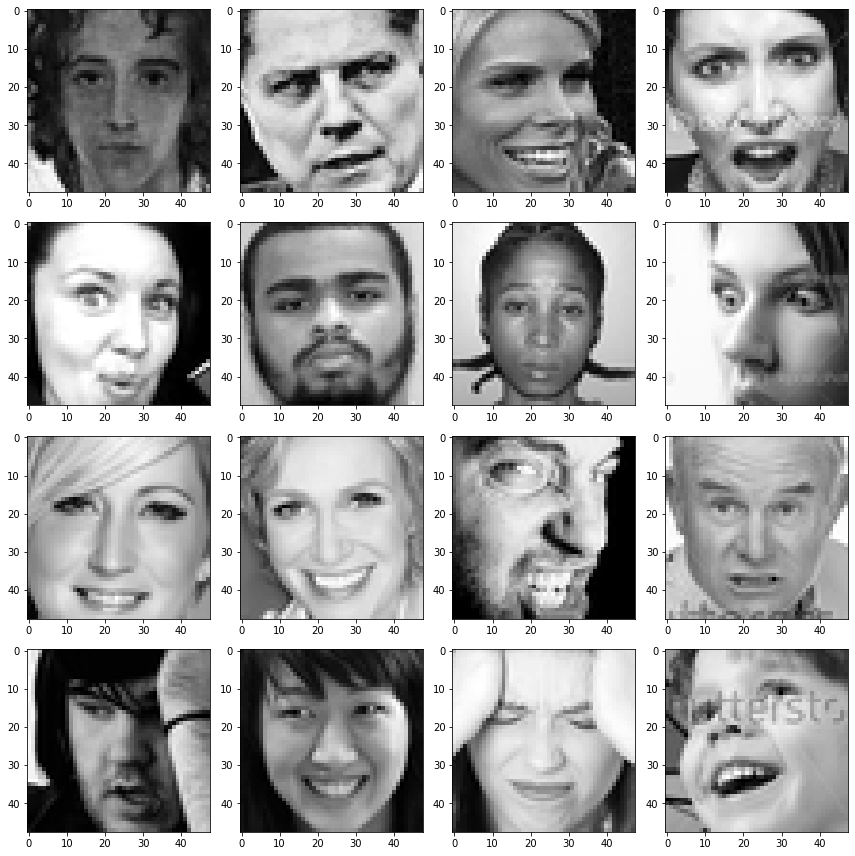

In [94]:
plt.figure(0, figsize=(12,12))
for i in range(101, 117):
    plt.subplot(4,4,i-100)
    plt.imshow(test_images[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

## This one is for AveragePooling as last layer, very bad performance in the last layer

conv2d_51


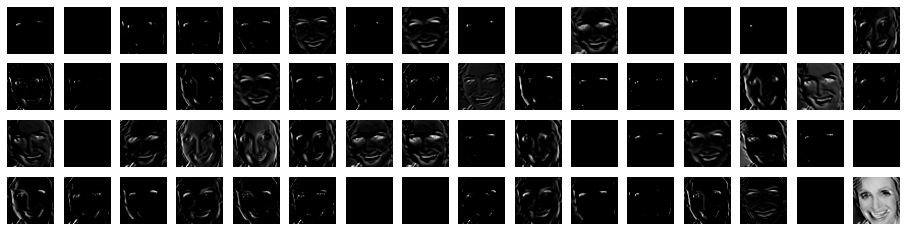

max_pooling2d_15


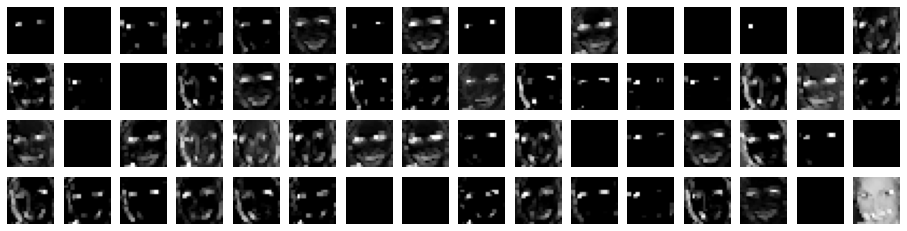

conv2d_52


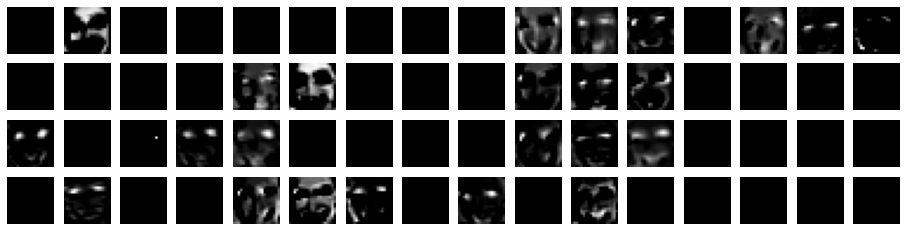

conv2d_53


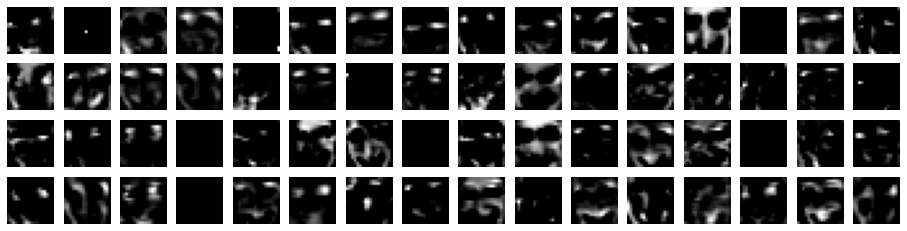

average_pooling2d_10


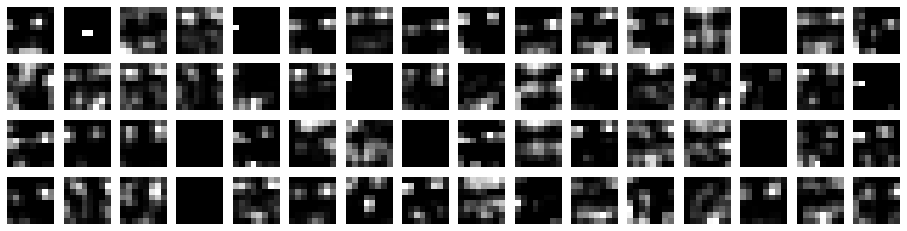

conv2d_54


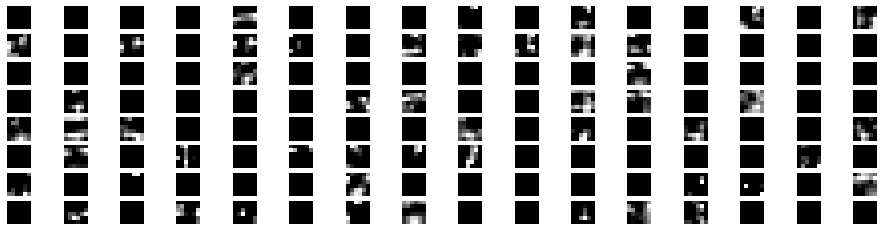

conv2d_55


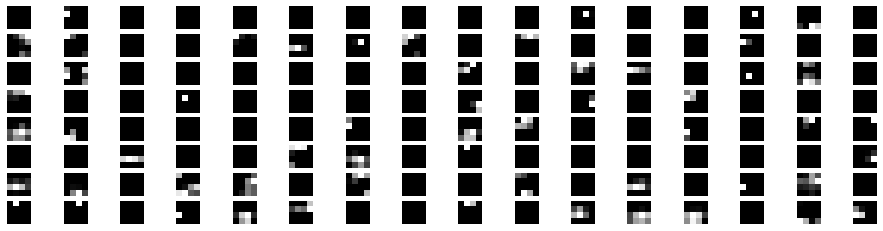

max_pooling2d_16


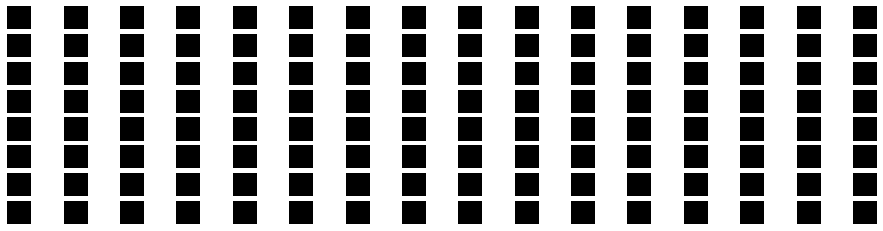

In [198]:
for i in range(0,len(model1.layers)-6):
    print(model1.layers[i].name)
    get_output_after_filter(model1, i, 110)

In [178]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_29 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 conv2d_30 (Conv2D)          (None, 18, 18, 64)        36928     
                                                                 
 flatten_8 (Flatten)         (None, 20736)             0         
                                                                 
 dense_24 (Dense)            (None, 128)               2654336   
                                                      

In [170]:
model.layers[0].name

'conv2d_28'

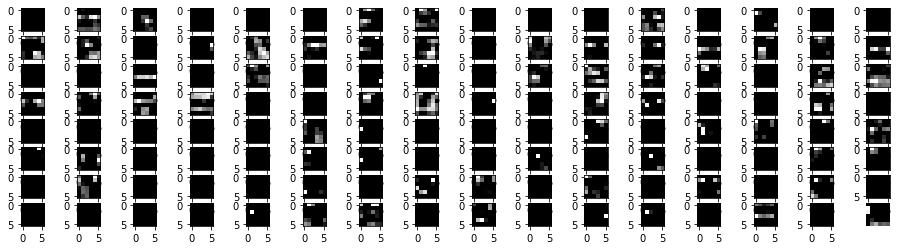

In [156]:
get_output_after_filter(model1, 5, 16)